In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv('water_potability.csv')
df

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


### Checking if the Target variable is balanced

Target Variable Balance:
 0    1998
1    1278
Name: Potability, dtype: int64


Text(0.5, 1.0, 'Potability Distribution')

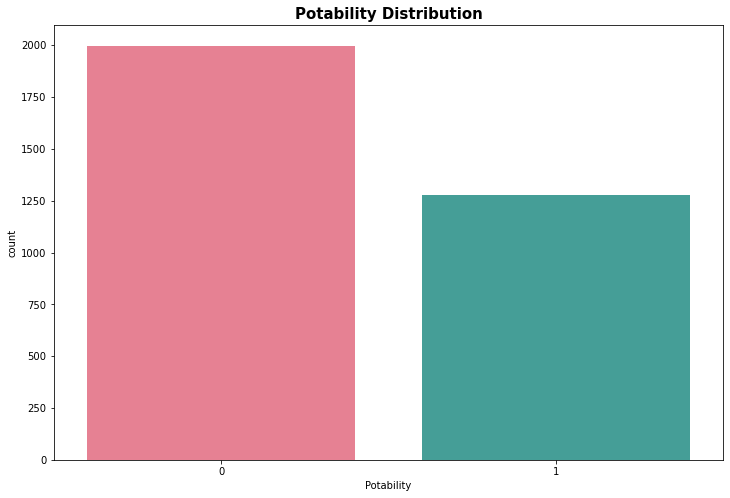

In [4]:
class_balance =df['Potability'].value_counts()
print('Target Variable Balance:\n',class_balance)
plt.figure(figsize=(12,8))
sns.countplot(data = df, x='Potability', palette = 'husl')
plt.title('Potability Distribution',size = 15, weight = 'bold')

### Target Variable has a ratio of 61% to 39% ratio. This dataset is not a highly imbalanced dataset. However balancing the target variable may help in our analysis

# Handling Missing Values

In [5]:
#pip install missingno

Null Values:
 ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64


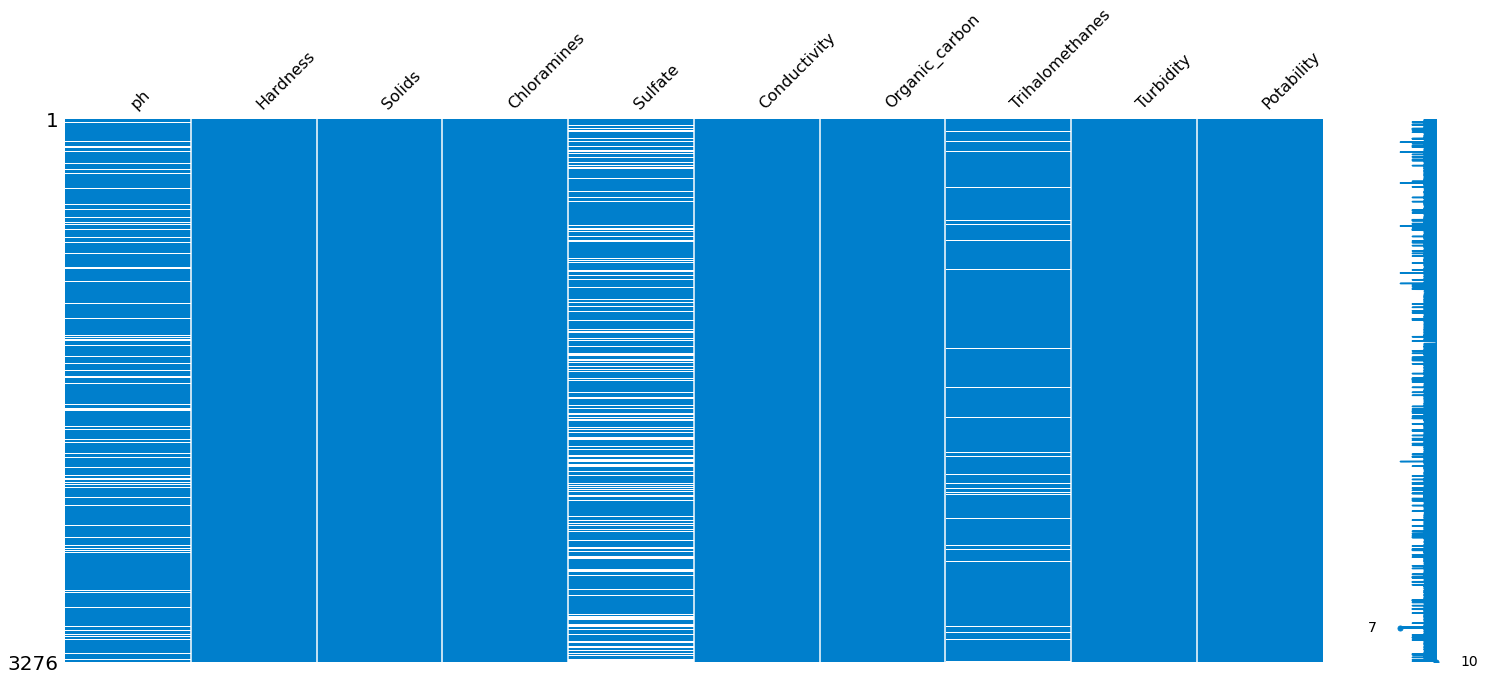

In [6]:
null_info = df.isnull().sum()

import missingno as msno

fig = msno.matrix(df,color=(0,0.5,0.8))

print('Null Values:\n',null_info)

<AxesSubplot:>

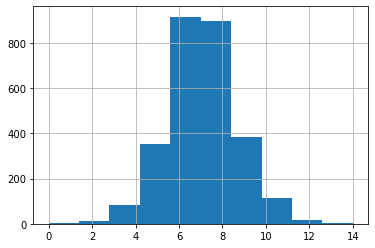

In [7]:
df['ph'].hist()

<AxesSubplot:>

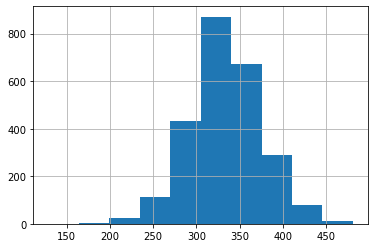

In [8]:
df['Sulfate'].hist()

<AxesSubplot:>

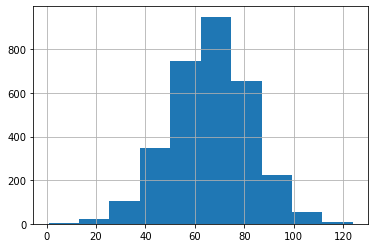

In [9]:
df['Trihalomethanes'].hist()

In [10]:
# With the distribution of these columns seen, we can replace the missing values with the mean value.

In [11]:
df['ph'] = df['ph'].fillna(df['ph'].mean())
df['Sulfate'] = df['Sulfate'].fillna(df['Sulfate'].mean())
df['Trihalomethanes'] = df['Trihalomethanes'].fillna(df['Trihalomethanes'].mean())


<AxesSubplot:>

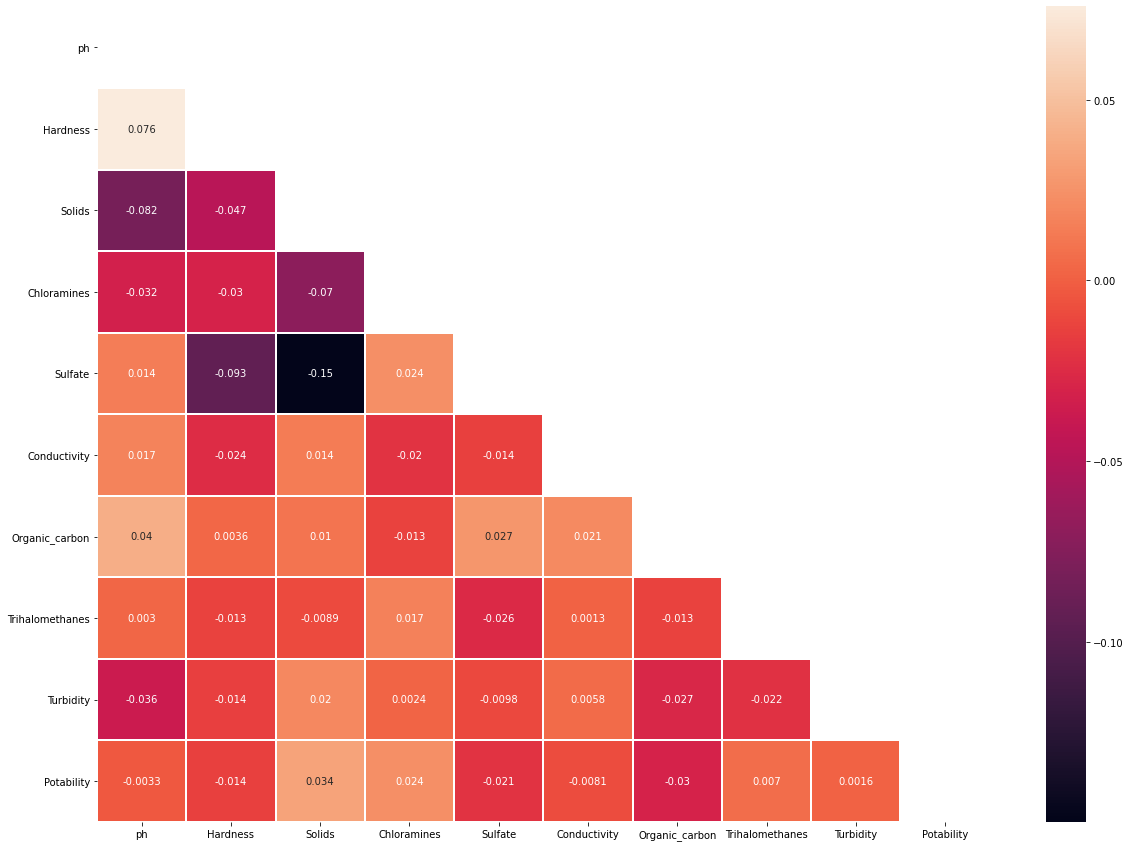

In [12]:
plt.figure(figsize=(20,15))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(),annot=True,linewidth=1,mask=matrix,cmap='rocket')

In [13]:
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier



from sklearn.model_selection import train_test_split,cross_val_score, cross_validate,RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [14]:
X = df.drop('Potability', axis = 1)
y = df['Potability']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.15, random_state = 42)


X_train.shape,y_train.shape

((2784, 9), (2784,))

In [16]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train,y_train, test_size = 0.2, random_state = 42)


In [17]:
X_train_val.shape,y_train_val.shape

((2227, 9), (2227,))

In [18]:
X_test.shape,y_test.shape

((492, 9), (492,))

In [19]:
X_train.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
dtype: int64

# Standardization

In [20]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train_val)
X_test_scaled = sc.transform(X_test_val)

In [21]:
X_train_scaled.shape

(2227, 9)

# SVM Model

## Base SVM Model unscaled data

In [22]:
#Initialize the model
SVC_model = SVC(random_state = 0)

# Fitting the model to our features and labels
SVC_model.fit(X_train_val, y_train_val)

# Traning score for the model
SVC_train_score = SVC_model.score(X_train_val,y_train_val)
print('Training Score :',SVC_train_score)

# # Predicting the labels for the test dataset
# prediction = SVC_model.predict(X_test)

# # Calculating the test score
# SVC_test_score = accuracy_score(y_test, prediction)
# print('Testing score:',SVC_test_score)

Training Score : 0.6084418500224518


### Classification Report

In [23]:
#print(classification_report(y_test,prediction, zero_division = True))

### Confusion Matrix

In [24]:
# SVC_matrix = confusion_matrix(y_test,prediction)
# sns.heatmap(SVC_matrix/np.sum(SVC_matrix),annot = True, fmt = '0.2%',cmap='Blues')

## Base SVM Model scaled data

In [25]:
#Initialize the model
SVC_scaled_model = SVC()

# Fitting the model to our features and labels
SVC_scaled_model.fit(X_train_scaled, y_train_val)

# Traning score for the model
SVC_scaled_train_score = SVC_scaled_model.score(X_train_scaled,y_train_val)
print('Training Score :',SVC_scaled_train_score)

# # Predicting the labels for the test dataset
# scaled_prediction = SVC_scaled_model.predict(X_test_scaled)

# # Calculating the test score
# SVC_scaled_test_score = accuracy_score(y_test, scaled_prediction)
# print('Testing score:',SVC_scaled_test_score)

Training Score : 0.7265379434216435


In [26]:
# Classification Report after scaling

In [27]:
# print(classification_report(y_test,scaled_prediction, zero_division = True))

In [28]:
# Confusion Matrix after scaling

In [29]:
# SVC_matrix_scaled = confusion_matrix(y_test,scaled_prediction)
# sns.heatmap(SVC_matrix_scaled/np.sum(SVC_matrix_scaled),annot = True, fmt = '0.2%',cmap='Greens')

In [30]:
# SVC_cv_model = SVC()

# SVC_cv_scores = cross_validate(SVC_cv_model, X_train_scaled, y_train,scoring = ['accuracy','precision_weighted','recall_weighted','f1_weighted'], cv = 10)

# SVC_cv_scores = pd.DataFrame(SVC_cv_scores, index = range(1,11))

# SVC_cv_scores

In [31]:
# SVC_cv_scores.mean()[2:]

## Hyperparameter Tuning for SVC model

In [32]:
# model.get_params()

In [33]:
%%time

SVC_grid_model = SVC()

parameters = {'C':[0.1,1,100,1000],
              'kernel': ['rbf'],
              'gamma':['auto','scale'],
              'degree':[1,2,3,4,5],
              'probability':[True, False]
             }

random_search = RandomizedSearchCV(estimator = SVC_grid_model,
                                   param_distributions = parameters,
                                   cv=3)
random_search.fit(X_train, y_train)


CPU times: user 25.3 s, sys: 54.8 ms, total: 25.3 s
Wall time: 25.5 s


RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': [0.1, 1, 100, 1000],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': ['auto', 'scale'],
                                        'kernel': ['rbf'],
                                        'probability': [True, False]})

In [34]:
random_search.best_params_

{'probability': False,
 'kernel': 'rbf',
 'gamma': 'scale',
 'degree': 3,
 'C': 1000}

In [35]:
# %%time

# SVC_grid_model = SVC()

# parameters = {'C':[0.1,1],
#               'kernel': ['linear'],
#               'gamma':['auto','scale']
#               #'degree':[1,2,3,4,5],
#               #'probability':[True, False]
#              }

# random_search = RandomizedSearchCV(estimator = SVC_grid_model,
#                                    param_distributions = parameters,
#                                    cv=3)
# random_search.fit(X_train, y_train)
# random_search.best_params_

In [ ]:
%%time

SVC_grid_model = SVC()

parameters = {'C':[0.1,1],
              'kernel': ['poly'],
              'gamma':['auto','scale'],
              'degree':[1,2,3,4,5],
              #'probability':[True, False]
             }

random_search = RandomizedSearchCV(estimator = SVC_grid_model,
                                   param_distributions = parameters,
                                   cv=3)
random_search.fit(X_train, y_train)

In [ ]:
random_search.best_params_

In [ ]:
%%time

random_model = SVC(C= 1000,gamma = 'scale', kernel = 'rbf',degree= 4,probability = True)
random_model.fit(X_train_scaled,y_train_val)
train_random_score=random_model.score(X_train_scaled,y_train_val)
# Calculating the training score
print('Training Score :',train_random_score)

# test_random_score = random_model.predict(X_test_scaled)
# test_random_score = accuracy_score(y_test, test_random_score)

# # Calculating the test score
# print('Testing score:',test_random_score)



In [ ]:
# sheet = pd.DataFrame(random_search.cv_results_)
# sheet[['C','kernal','gamma','mean_test_score']]

In [ ]:
# Build a basic SVC model with confusion matrix

In [ ]:
# Do cross validation on the X_train and y_train 

In [ ]:
# SVC Model on scaled data

In [ ]:
# Cross validation on this data

In [ ]:
# Hyperparameter tuning
# 1) set the parameters list

# 2) use the Randomsearch CV or Gridsearch cv to check the best parameters

# 3) Fit the best model test the accuracy and classification report

# MLP Model

In [ ]:
mlp_model = MLPClassifier()

mlp_model.fit(X_train, y_train)

score_train= mlp_model.score(X_train,y_train)

mlp_pred = mlp_model.predict(X_test)

score_test = accuracy_score(y_test,mlp_pred)

In [ ]:
score_train

In [ ]:
score_test

In [ ]:
# Hyper parameters

In [ ]:
mlp_params = {"alpha": [0.1,0.01,0.05,0.001,0.0001],
              "hidden_layer_sizes":[(10,10,10),(100,100,100),(100,100)],
              "solver": ["adam","sgd"],
              "activation":["relu","tanh"]}

In [ ]:
mlp_model2 = MLPClassifier(max_iter= 2000)

cv_mlp_model2 = GridSearchCV(mlp_model2,mlp_params,cv= 10,n_jobs = -1,verbose = 2)

cv_mlp_model2.fit(X_train,y_train)

cv_mlp_model2.best_params_

In [ ]:
tuned_mlp = MLPClassifier(activation = "tanh", alpha = 0.001,hidden_layer_sizes = (100,100,100),solver = 'sgd',max_iter = 5000)

tuned_mlp.fit(X_train, y_train)

tuned_score_train = tuned_mlp.score(X_train, y_train)

tuned_pred = tuned_mlp.predict(X_test)

tuned_score_test = accuracy_score(y_test,tuned_pred)

In [ ]:
tuned_score_train

In [ ]:
tuned_score_test

In [ ]:
WHO_LIMITS={
    'ph': [6.5, 8.5], # [min, max]
    # 'Solids': 1000, # max 
    # 'Chloramines': 4, # max
    # 'Sulfate': [3, 30], # In most fresh water supplies
    # 'Conductivity': 400, # max
    # 'Organic_carbon': 2, # max
    'Trihalomethanes': 80 # max
}